### Import Packages

In [1]:
import pandas as pd
import numpy as np

from time import time

from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost

import seaborn as sns
import matplotlib.pyplot as plt


import seaborn as sns; sns.set()
%matplotlib inline

### Data Upload and Analysis - Training Dataset

In [2]:
train_df = pd.read_csv('train.csv')

In [3]:
train_df.head(2)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200


In [4]:
train_df.shape

(550068, 12)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [6]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
User_ID,550068.0,1.003029e+06,1727.591586,1000001.0,1001516.0,1003077.0,1004478.0,1006040.0
Occupation,550068.0,8.076707e+00,6.522660,0.0,2.0,7.0,14.0,20.0
Marital_Status,550068.0,4.096530e-01,0.491770,0.0,0.0,0.0,1.0,1.0
Product_Category_1,550068.0,5.404270e+00,3.936211,1.0,1.0,5.0,8.0,20.0
Product_Category_2,376430.0,9.842329e+00,5.086590,2.0,5.0,9.0,15.0,18.0
Product_Category_3,166821.0,1.266824e+01,4.125338,3.0,9.0,14.0,16.0,18.0
Purchase,550068.0,9.263969e+03,5023.065394,12.0,5823.0,8047.0,12054.0,23961.0


In [7]:
train_df.describe(include=['O']).T

,count,unique,top,freq
Product_ID,550068,3631,P00265242,1880
Gender,550068,2,M,414259
Age,550068,7,26-35,219587
City_Category,550068,3,B,231173
Stay_In_Current_City_Years,550068,5,1,193821


* ### Target 

In [8]:
df_copy = train_df.copy()

/Users/jessicagarre/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Purchase', ylabel='Density'>

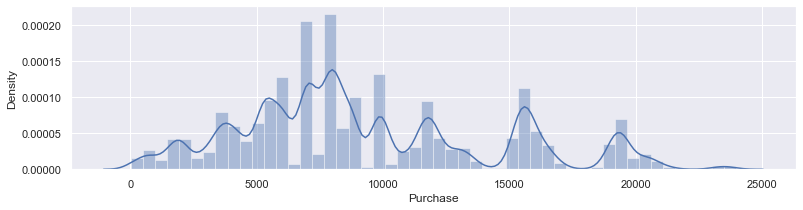

In [9]:
# Distribution of target variable
fig, ax = plt.subplots(figsize = (13, 3))
sns.distplot(df_copy.Purchase, ax = ax)

<AxesSubplot:xlabel='Purchase'>

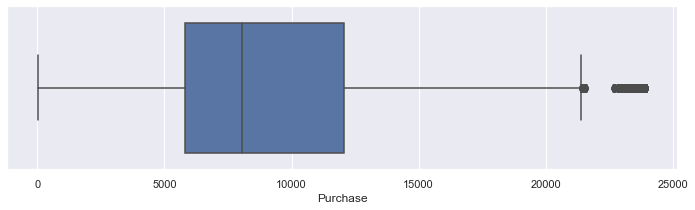

In [10]:
fig, ax = plt.subplots(figsize=(12, 3))
sns.boxplot(x = 'Purchase', data = train_df)

* ### Correlations

We will create a copy of the dataframe and do some transformations on the features in order to obtain the correlation matrix and see their relationship. For that we need to make them numeric. 

In [11]:
df_copy.Product_ID = df_copy['Product_ID'].str.replace('P', '').astype(int)

In [12]:
city_codes = {'M':1, 'F':2}

df_copy.Gender = df_copy.Gender.map(city_codes).astype(int)

In [13]:
ages_list = df_copy.Age.value_counts().keys().tolist()
myorder = [6, 0, 1, 2, 3, 4, 5]
ages_list = [ages_list[i] for i in myorder]

values = [x for x in range(0,7,1)]

ages_dict = {}
for i in values:
    ages_dict[ages_list[i]] = i
    
df_copy.Age = df_copy.Age.map(ages_dict).astype(int)

In [14]:
city_codes = {'A':1, 'B':2, 'C':3}

df_copy.City_Category = df_copy.City_Category.map(city_codes).astype(int)

In [15]:
df_copy.Stay_In_Current_City_Years = df_copy.Stay_In_Current_City_Years.apply(lambda x: int(x.replace('+', '')))

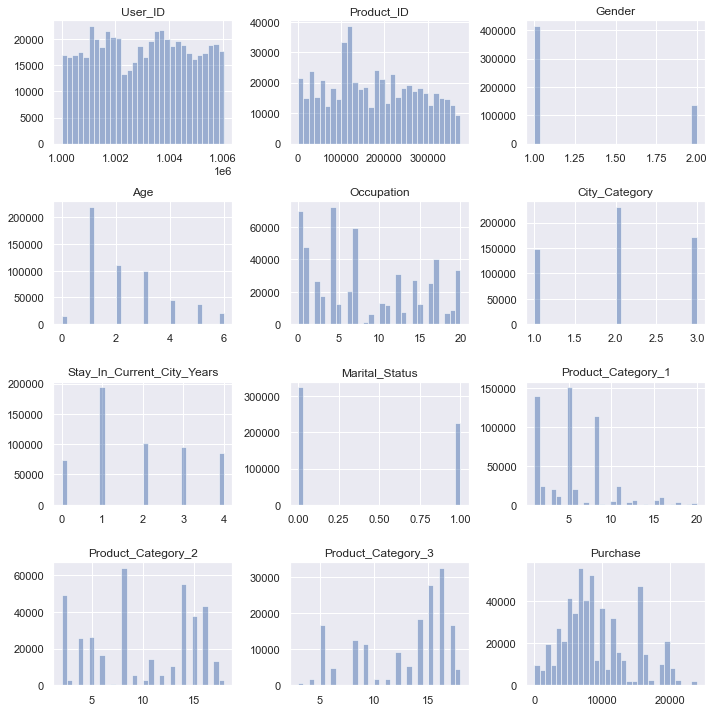

In [16]:
df_copy.hist(alpha=0.5, bins=30, figsize=(10, 10))
plt.tight_layout()
plt.show()

In [17]:
def graph_respect_mean_purchase(col):
    
    df = train_df.groupby(col)['Purchase'].mean().to_frame('Purchase_Mean').reset_index()
    
    fig = plt.figure(figsize=(4,3))

    plt.bar(df[col], df['Purchase_Mean'], alpha=0.5)
    
    fig.suptitle(col + ' - Mean Purchase', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Mean Purchase', fontsize=12)
    plt.tight_layout()
    plt.show()

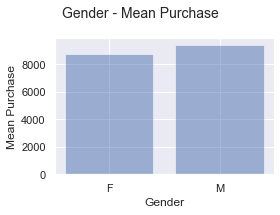

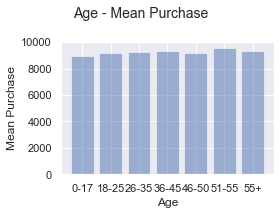

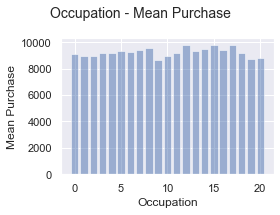

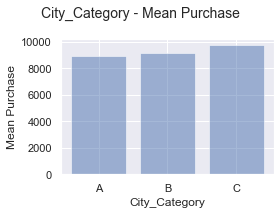

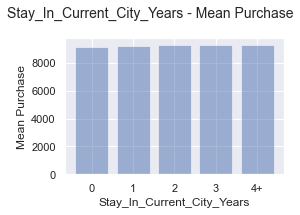

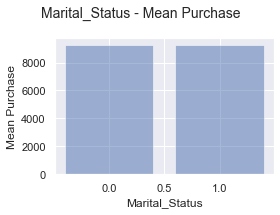

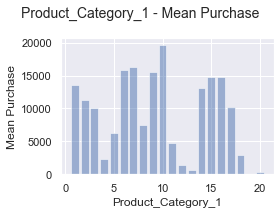

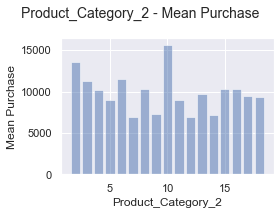

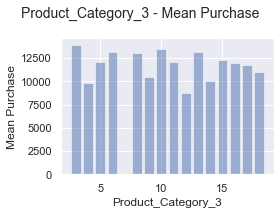

In [18]:
for col in df_copy.columns[2:-1]:
    graph_respect_mean_purchase(col)

<AxesSubplot:xlabel='Product_Category_3', ylabel='Purchase'>

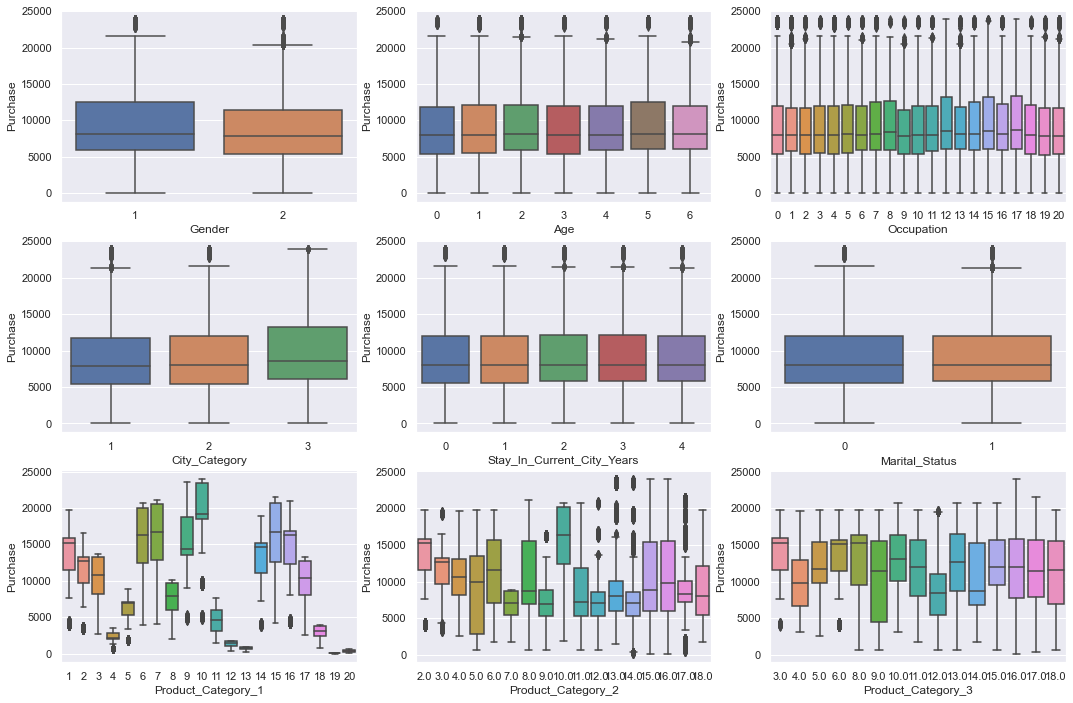

In [19]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (18, 12))

sns.boxplot(x = 'Gender'    , y = 'Purchase', data = df_copy, orient = 'v', dodge = False, ax = axs[0, 0])
sns.boxplot(x = 'Age'       , y = 'Purchase', data = df_copy, orient = 'v', dodge = False, ax = axs[0, 1])
sns.boxplot(x = 'Occupation', y = 'Purchase', data = df_copy, orient = 'v', dodge = False, ax = axs[0, 2])

sns.boxplot(x = 'City_Category'             , y = 'Purchase', data = df_copy, orient = 'v', dodge = False, ax = axs[1, 0])
sns.boxplot(x = 'Stay_In_Current_City_Years', y = 'Purchase', data = df_copy, orient = 'v', dodge = False, ax = axs[1, 1])
sns.boxplot(x = 'Marital_Status'            , y = 'Purchase', data = df_copy, orient = 'v', dodge = False, ax = axs[1, 2])

sns.boxplot(x = 'Product_Category_1', y = 'Purchase', data = df_copy, orient = 'v', dodge = False, ax = axs[2, 0])
sns.boxplot(x = 'Product_Category_2', y = 'Purchase', data = df_copy, orient = 'v', dodge = False, ax = axs[2, 1])
sns.boxplot(x = 'Product_Category_3', y = 'Purchase', data = df_copy, orient = 'v', dodge = False, ax = axs[2, 2])

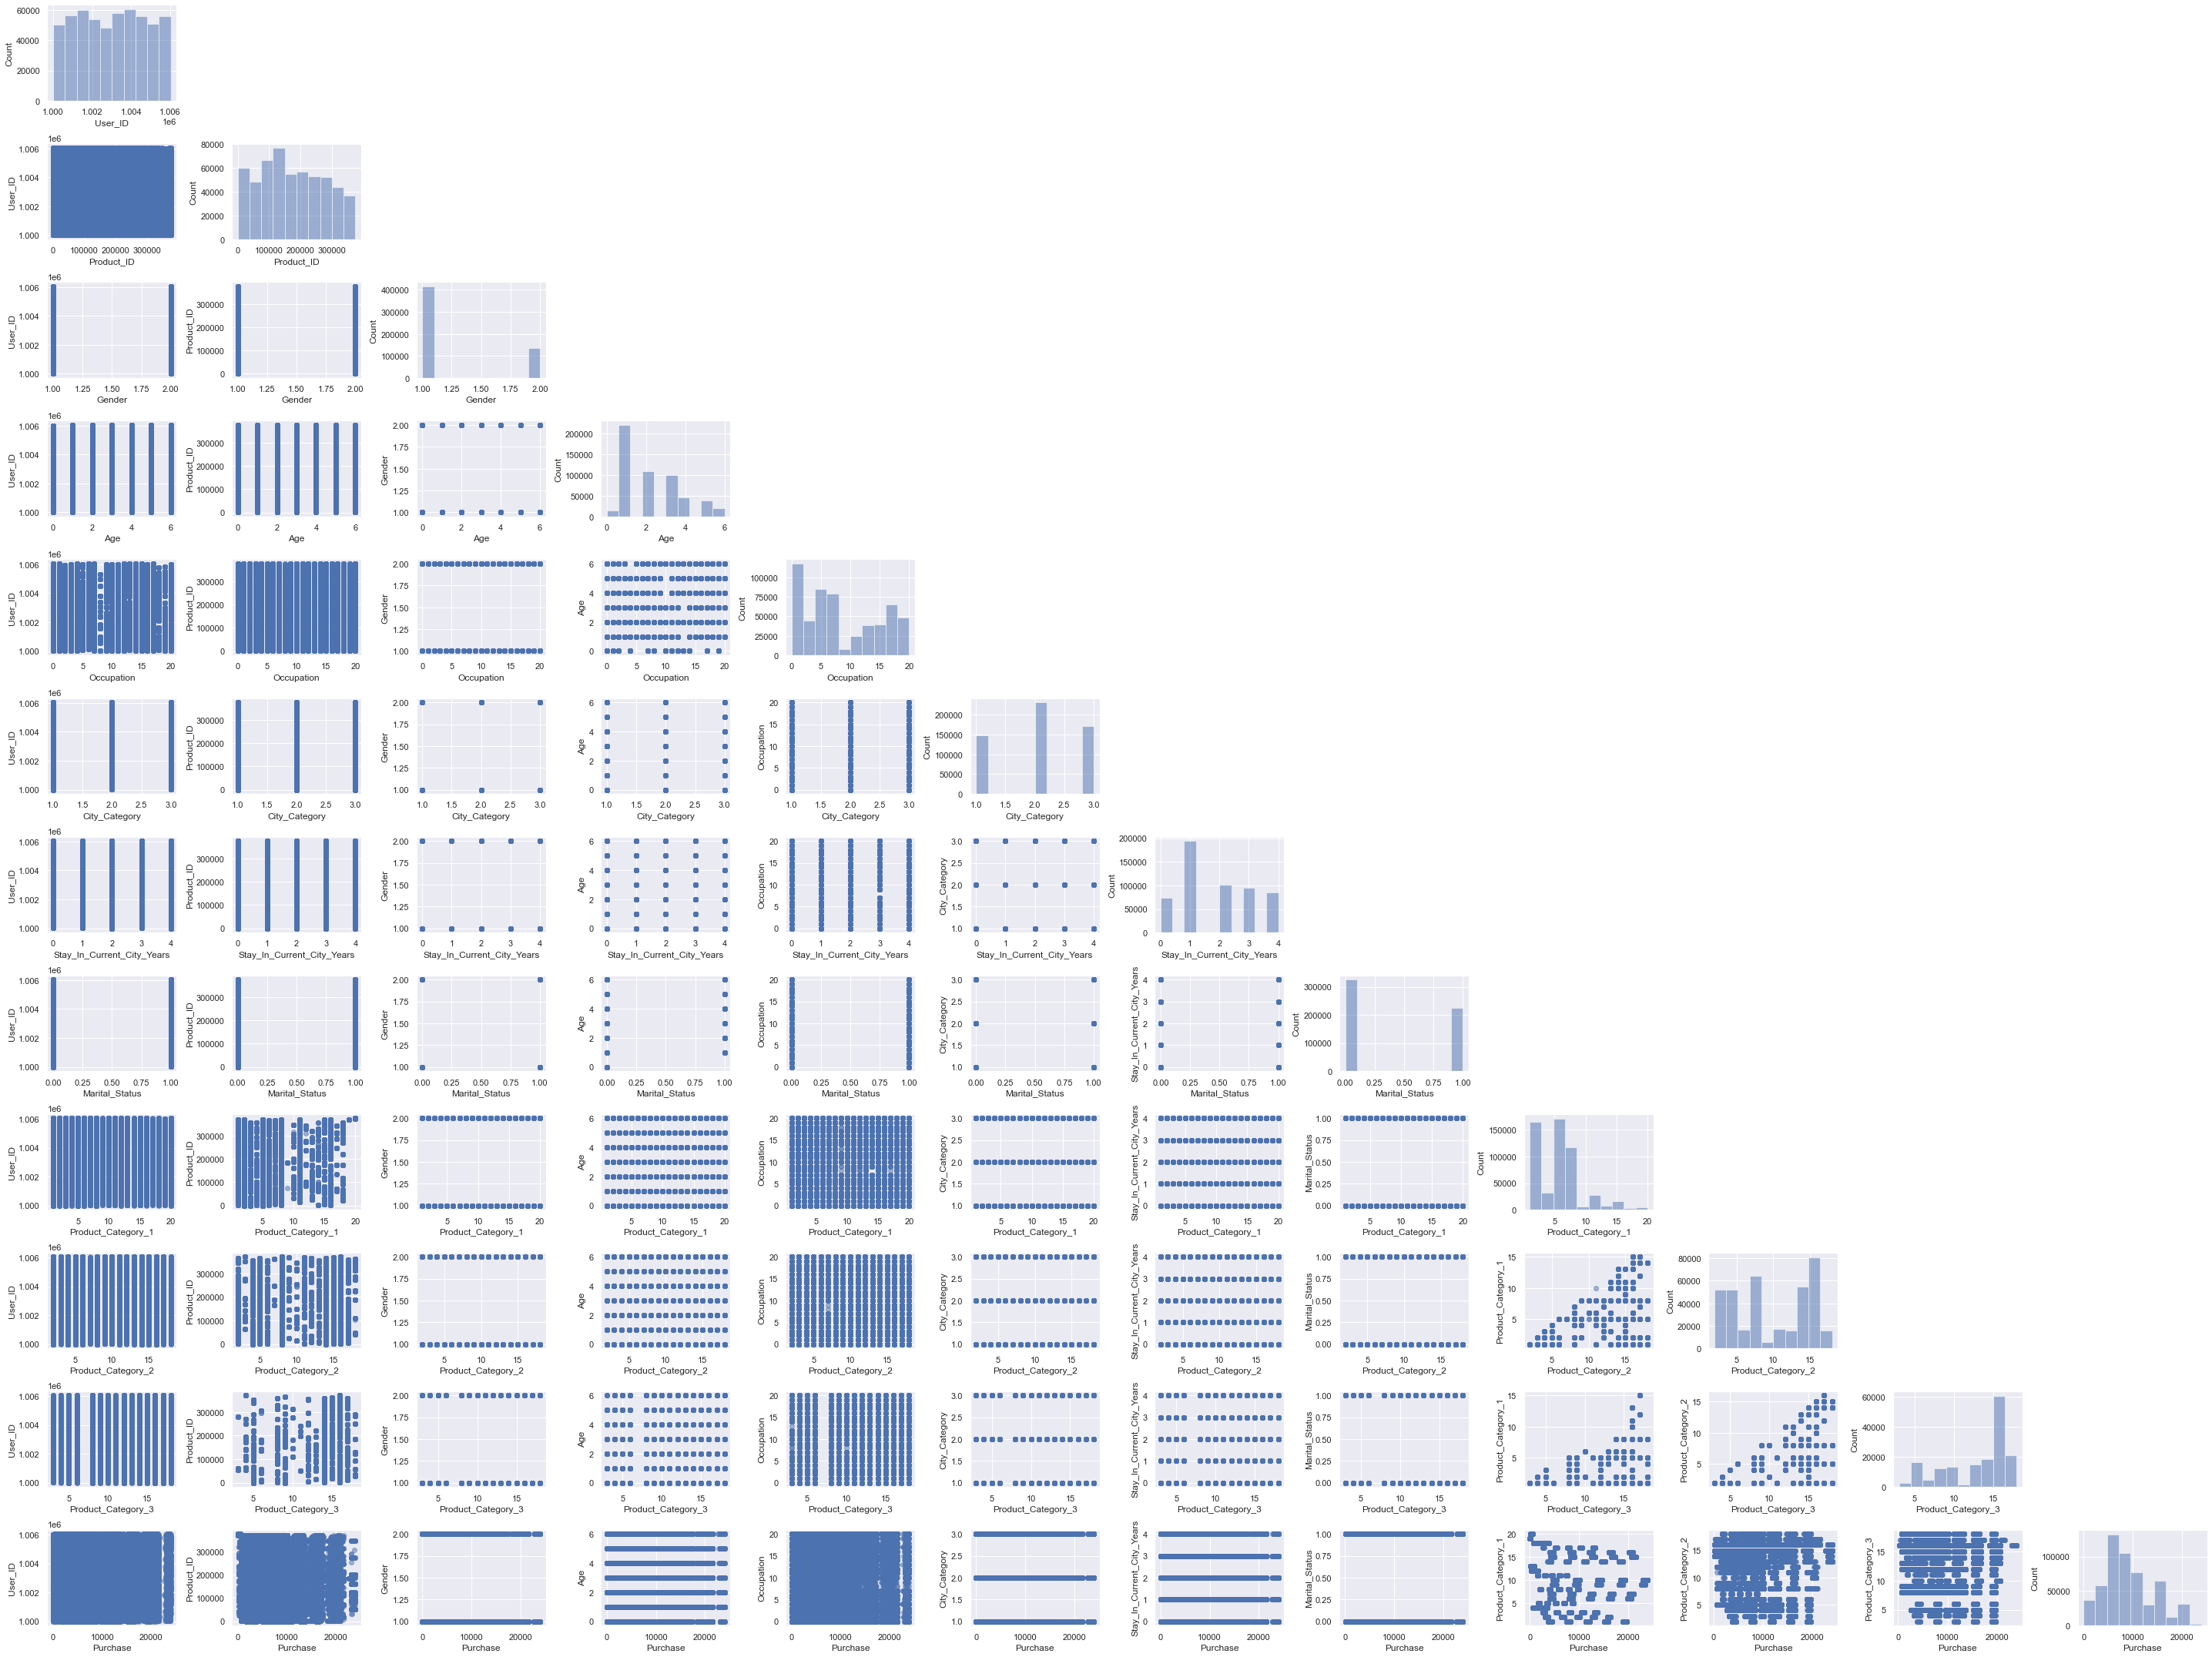

In [20]:
scatterplotmatrix(df_copy.values, figsize=(40, 30), names=df_copy.columns, alpha=0.5)
plt.tight_layout()
plt.show()

In [21]:
corr = df_copy.corr()
corr

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
User_ID,1.000000,-0.017619,0.033474,-0.018232,-0.023971,0.022859,-0.030737,0.020443,0.003825,0.001529,0.003419,0.004716
Product_ID,-0.017619,1.000000,-0.021084,0.017143,0.009344,0.010162,-0.003162,0.013194,0.090193,0.034114,0.044938,-0.103961
Gender,0.033474,-0.021084,1.000000,0.013803,-0.117291,0.004515,-0.014660,0.011603,0.045594,0.018591,-0.028069,-0.060346
Age,-0.018232,0.017143,0.013803,1.000000,0.024902,0.141887,-0.022247,0.198470,0.040627,0.030500,0.033782,0.008643
Occupation,-0.023971,0.009344,-0.117291,0.024902,1.000000,0.034479,0.030005,0.024280,-0.007618,-0.000384,0.013263,0.020833
City_Category,0.022859,0.010162,0.004515,0.141887,0.034479,1.000000,0.019946,0.039790,-0.014364,-0.011822,-0.002347,0.061914
Stay_In_Current_City_Years,-0.030737,-0.003162,-0.014660,-0.022247,0.030005,0.019946,1.000000,-0.012819,-0.004213,-0.001657,0.002093,0.005422
Marital_Status,0.020443,0.013194,0.011603,0.198470,0.024280,0.039790,-0.012819,1.000000,0.019888,0.015138,0.019473,-0.000463
Product_Category_1,0.003825,0.090193,0.045594,0.040627,-0.007618,-0.014364,-0.004213,0.019888,1.000000,0.540583,0.229678,-0.343703
Product_Category_2,0.001529,0.034114,0.018591,0.030500,-0.000384,-0.011822,-0.001657,0.015138,0.540583,1.000000,0.543649,-0.209918


In [22]:
def corr_heatmap(corr):
    plt.figure(figsize = (10,7))

    ax = sns.heatmap(corr, 
                     vmin=-1, vmax=1, center=0,
                     cmap=sns.diverging_palette(20, 220, n=200))

    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right');

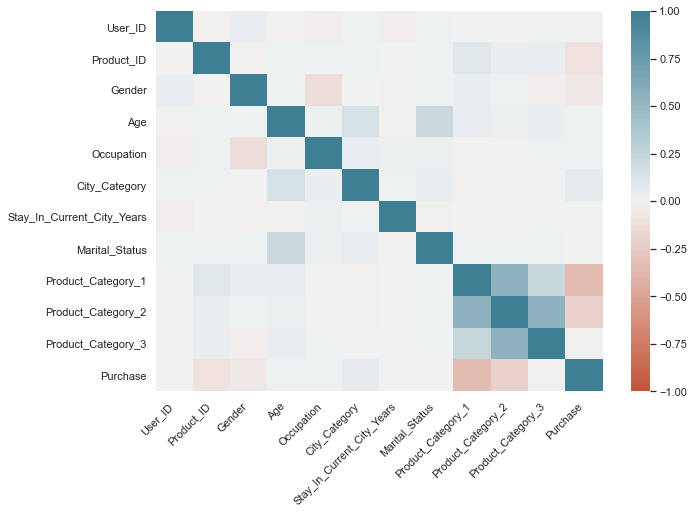

In [23]:
corr_heatmap(corr)

### Data Preprocessing - Training Dataset

* #### Separate target from input data

In [24]:
target   = train_df.Purchase
features = train_df.drop('Purchase', axis=1)

* #### Check Null Values

In [25]:
features.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
dtype: int64

In [26]:
target.isnull().sum()

0

In [27]:
for col in features.columns:
    
    if features[col].isnull().sum() != 0:
        print('{}: {}% null values'.format(col, np.round(features[col].isnull().sum()*100/len(features), 2)))
        
        # We will substitute the null values by 999 just as an identifier of null values. 
        # We were going to use zero values but, just in case there is already a value 0 on the  
        # variable (if not now in future test datasets), we will use this identifier.
        # This will be useful when later applying one-hot encoding.
        features[col].fillna(-999, inplace=True)
    
    else:
        continue

Product_Category_2: 31.57% null values
Product_Category_3: 69.67% null values


We just have two columns with null values, actually high proportion of null values. However, since these specific columns correspond to sub-categories of the products, it is normal that some products do not have sub-categories, thus it is representative for the model and we will leave as 0. 

* #### Handle ID Variables

We will remove Client IDs as it is not relevant for the analysis, and will transform the Product ID variable, as the product itself should not be relevant for the study but some metrics related to it are, as some products are more purchased than others (we could see it before when plotting the frequency according to the variables). 

In [29]:
features.Product_ID = features.Product_ID.str.replace('P', '').astype(int)

In [30]:
features.drop(['User_ID'], axis=1, inplace=True)

* #### Categoric Variables - One-Hot Encoding

All variables on the current features dataframe are categoric but the Product_Popularity (which we created), thus we will be performing the steps needed in order to assure that their categoric influence is maintained while in the right format for the predictive model. 

These are the user's gender (Gender), age range (Age), the user's occupation (Occupation), the city (City_Category), the marital status (Marital_Status), the years the client has been in the city (Stay_In_Current_City_Years), and the products categories (Product_Category_1, Product_Category_2, Product_Category_3).

In [31]:
categ_cols = features.columns[:-1].tolist()

In [32]:
print('Number of distinct values on each of the categorical variables:\n')
for col in categ_cols:
    print('{}: {}'.format(col, len(features[col].unique())))

Number of distinct values on each of the categorical variables:

Product_ID: 3631
Gender: 2
Age: 7
Occupation: 21
City_Category: 3
Stay_In_Current_City_Years: 5
Marital_Status: 2
Product_Category_1: 20
Product_Category_2: 18


We will appply one-hot encoding to all categoric variables but Marital Status, which is already provided as binary. 

In [33]:
dummy_cols = ['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years']

In [34]:
dummies = pd.get_dummies(features[dummy_cols])
dummies.head(2)

,Gender_F,Gender_M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,City_Category_A,City_Category_B,City_Category_C,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+
0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [35]:
# Drop original names from categorical variables
features.drop(dummy_cols, axis=1, inplace=True)

# Concat dummies within features
features = pd.concat([features, dummies], axis=1)
features.head(2)

,Product_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Gender_F,Gender_M,Age_0-17,Age_18-25,...,Age_51-55,Age_55+,City_Category_A,City_Category_B,City_Category_C,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+
0,69042,10,0,3,-999.0,-999.0,1,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,248942,10,0,1,6.0,14.0,1,0,1,0,...,0,0,1,0,0,0,0,1,0,0


### Scale Data - Training Dataset

* #### Split train and validation sets

In [36]:
# Split the training data into training and validation, which will be used to test the model
X_train, X_valid, y_train, y_valid = train_test_split(features, 
                                                      target, 
                                                      test_size = 0.2, 
                                                      random_state = 0)

* #### Scaler

In [37]:
scaler = StandardScaler()

In [38]:
X_train_scaled = scaler.fit_transform(X_train)

In [39]:
X_train_scaled[0]

array([-1.23433628, -0.16532547,  1.20119025,  0.65999022, -1.47197373,
       -0.65951912, -0.5724713 ,  0.5724713 , -0.16867692, -0.47032106,
        1.22628625, -0.4994787 , -0.3011023 , -0.27414673, -0.20174387,
       -0.60571138, -0.85075387,  1.48597293, -0.39553924, -0.73672667,
       -0.47626283, -0.45870761,  2.34223641])

In [40]:
X_valid_scaled = scaler.transform(X_valid)

### Function to Automatize Data Preparation

In [87]:
def data_engineering(X_data):
    
    X_data_processed = X_data.copy()
    
    # Null Values
    for col in X_data_processed.columns:
    
        if X_data_processed[col].isnull().sum() != 0:
            X_data_processed[col].fillna(-999, inplace=True)
        else:
            continue
            
            
    # Handle ID Variables
    X_data_processed.Product_ID = X_data_processed.Product_ID.str.replace('P', '').astype(int)
    
    X_data_processed.drop(['User_ID'], axis=1, inplace=True)

    # One-hot encoding
    dummies = pd.get_dummies(X_data_processed[dummy_cols])
    
    X_data_processed.drop(dummy_cols, axis=1, inplace=True)
    
    X_data_processed = pd.concat([X_data_processed, dummies], axis=1)
    
    for col in X_train.columns:
        if col not in X_data_processed.columns:
            X_data_processed[col] = 0

    # Scaler
    X_data_scaled = scaler.transform(X_data_processed)
    
    return X_data_processed, X_data_scaled

### Model Implementation

In [42]:
def train_predict(model, X_train, y_train, X_valid, y_valid):
    
    '''
    inputs:
       - model: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: target training set
       - X_valid: features testing set
       - y_valid: target testing set
    '''
    
    # Fit the model within the training data, slicing it by 'sample_size'. Obtain training time
    start = time()
    model = model.fit(X_train, y_train)
    end = time()
    
    train_time = end - start

    # Predict target on the train and test sets and obtain total prediction time
    start = time()
    predictions_train = model.predict(X_train) # For training, we just predict the first 300 samples
    predictions_valid = model.predict(X_valid)
    end = time()
    
    pred_time = end - start

    # Calculate MAE, MSE and R2 Score on train set
    mae_train  = mean_absolute_error(y_train, predictions_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))
    r2_train   = r2_score(y_train, predictions_train)

    # Calculate MAE and MSE on test set
    mae_valid  = mean_absolute_error(y_valid, predictions_valid)
    rmse_valid = np.sqrt(mean_squared_error(y_valid, predictions_valid))
    r2_valid   = r2_score(y_valid, predictions_valid)
    
    print('{}:'.format(model.__class__.__name__))
    print('MAE       - Train: {:.2f}, Valid: {:.2f}'.format(mae_train, mae_valid))
    print('RMSE      - Train: {:.2f}, Valid: {:.2f}'.format(rmse_train, rmse_valid))
    print('R2 score: - Train: {:.2f}, Valid: {:.2f}'.format(r2_train, r2_valid))
    print('Training time: {:.2f}, Prediction time {:.2f}.\n'.format(train_time, pred_time))

* #### Choosing Model

In [43]:
# Initialize models whose performance we are going to test
model_A = LinearRegression()
model_B = RANSACRegressor(LinearRegression(), random_state = 42)
model_C = RandomForestRegressor(random_state = 42)
model_D = xgboost.XGBRegressor(random_state = 42)

models = [model_A, model_B, model_C, model_D]

In [44]:
# Collect results on the models

for clf in models:
    train_predict(clf, X_train, y_train, X_valid, y_valid)

LinearRegression:
MAE       - Train: 3505.34, Valid: 3511.55
RMSE      - Train: 4601.94, Valid: 4605.87
R2 score: - Train: 0.16, Valid: 0.16
Training time: 0.49, Prediction time 0.06.

RANSACRegressor:
MAE       - Train: 4023.38, Valid: 4035.98
RMSE      - Train: 5433.18, Valid: 5451.16
R2 score: - Train: -0.17, Valid: -0.18
Training time: 3.44, Prediction time 0.07.

RandomForestRegressor:
MAE       - Train: 901.35, Valid: 2090.57
RMSE      - Train: 1310.04, Valid: 2849.71
R2 score: - Train: 0.93, Valid: 0.68
Training time: 298.12, Prediction time 48.69.

XGBRegressor:
MAE       - Train: 1962.07, Valid: 1979.54
RMSE      - Train: 2621.07, Valid: 2647.98
R2 score: - Train: 0.73, Valid: 0.72
Training time: 67.20, Prediction time 1.94.



* #### Model Tuning - XGBoost

In [45]:
model = xgboost.XGBRegressor(random_state = 42)

In [46]:
from sklearn.model_selection import RandomizedSearchCV

In [47]:
parameters = {'learning_rate'   : [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0],
              'n_estimators'    : [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)],
              'max_depth'       : [int(x) for x in np.linspace(start = 5, stop = 20, num = 15)],
              'min_child_weight': [int(x) for x in np.linspace(start = 45, stop = 70, num = 15)],
              'gamma'           : [int(x) for x in np.linspace(start = 0.0, stop = 0.5, num = 5)],
              'colsample_bytree': [0.3, 0.4, 0.5, 0.7]}

In [48]:
xgboost_cv = RandomizedSearchCV(model, param_distributions=parameters, cv=5, random_state = 42)

xgboost_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          validate_parameters=None,
                                          verbosity=None),
                   param_distributions={'colsample_bytree': [0.

In [49]:
print('\n Best estimator:')
print(xgboost_cv.best_estimator_)
print('\n Best hyperparameters:')
print(xgboost_cv.best_params_)


 Best estimator:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.5, max_delta_step=0, max_depth=9,
             min_child_weight=48, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

 Best hyperparameters:
{'n_estimators': 300, 'min_child_weight': 48, 'max_depth': 9, 'learning_rate': 0.5, 'gamma': 0, 'colsample_bytree': 0.4}


In [50]:
pred_train = xgboost_cv.predict(X_train)
pred_valid = xgboost_cv.predict(X_valid)

In [51]:
# Calculate MAE, MSE and R2 Score on train set
mae_train  = mean_absolute_error(y_train, pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
r2_train   = r2_score(y_train, pred_train)

# Calculate MAE and MSE on test set
mae_valid  = mean_absolute_error(y_valid, pred_valid)
rmse_valid = np.sqrt(mean_squared_error(y_valid, pred_valid))
r2_valid   = r2_score(y_valid, pred_valid)

print('Optimized XGBoost Model: \n')
print('MAE       - Train: {:.2f}, Valid: {:.2f}'.format(mae_train, mae_valid))
print('RMSE      - Train: {:.2f}, Valid: {:.2f}'.format(rmse_train, rmse_valid))
print('R2 score: - Train: {:.2f}, Valid: {:.2f}'.format(r2_train, r2_valid))

Optimized XGBoost Model: 

MAE       - Train: 1788.32, Valid: 1911.29
RMSE      - Train: 2406.46, Valid: 2580.96
R2 score: - Train: 0.77, Valid: 0.74


* #### Model Tuning - RandomForest

In [99]:
model = RandomForestRegressor(random_state = 42)

In [100]:
parameters = {'n_estimators'     : [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
              'max_features'     : ['auto', 'sqrt'],
              'max_depth'        : [int(x) for x in np.linspace(10, 110, num = 11)],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf' : [1, 2, 4],
              'bootstrap'        : [True, False]}

In [ ]:
randomforest_cv = RandomizedSearchCV(model, param_distributions = parameters, cv = 5, random_state = 42)

randomforest_cv.fit(X_train, y_train)

In [ ]:
print('\n Best estimator:')
print(randomforest_cv.best_estimator_)
print('\n Best hyperparameters:')
print(randomforest_cv.best_params_)

In [ ]:
pred_train = randomforest_cv.predict(X_train)
pred_valid = randomforest_cv.predict(X_valid)

In [ ]:
# Calculate MAE, MSE and R2 Score on train set
mae_train  = mean_absolute_error(y_train, pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
r2_train   = r2_score(y_train, pred_train)

# Calculate MAE, MSE and R2 on test set
mae_valid  = mean_absolute_error(y_valid, pred_valid)
rmse_valid = np.sqrt(mean_squared_error(y_valid, pred_valid))
r2_valid   = r2_score(y_valid, pred_valid)

print('Optimized RandomForest Model: \n')
print('MAE       - Train: {:.2f}, Valid: {:.2f}'.format(mae_train, mae_valid))
print('RMSE      - Train: {:.2f}, Valid: {:.2f}'.format(rmse_train, rmse_valid))
print('R2 score: - Train: {:.2f}, Valid: {:.2f}'.format(r2_train, r2_valid))

### Test Predictions

In [88]:
test_df  = pd.read_csv('test.csv')

In [89]:
test_df.head(2)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000004,P00128942,M,46-50,7,B,2,1,1,11.0,NaN
1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,NaN


In [90]:
X_test, X_test_scaled = data_engineering(test_df)

In [92]:
pred_test = xgboost_cv.predict(X_test)

In [93]:
pred_test

array([17181.025 , 12384.139 ,  6572.4854, ...,  9214.396 , 18276.576 ,
        3107.8494], dtype=float32)

In [94]:
submission_df = test_df[['User_ID', 'Product_ID']]

In [95]:
submission_df['Purchase'] = pred_test

<ipython-input-95-656221b1911c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_df['Purchase'] = pred_test


In [96]:
submission_df.head(2)

,User_ID,Product_ID,Purchase
0,1000004,P00128942,17181.025391
1,1000009,P00113442,12384.138672


In [97]:
column_names = ['Purchase', 'User_ID', 'Product_ID']

submission_df = submission_df.reindex(columns=column_names)

In [98]:
submission_df.to_csv('Submission_BlackFriday_Sales.csv', index = False)